In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import fsspec

# from carbonplan_forest_risks import load, setup, plot, fit, utils, prepare, collect
from carbonplan_data import utils
import regionmask
import numpy as np
from numcodecs.zlib import Zlib

In [2]:
store = fsspec.get_mapper('https://carbonplan.blob.core.windows.net/carbonplan-forests/risks/results/web/fire.zarr')

ds = xr.open_zarr(store).coarsen(x=12, y=12, boundary='trim').mean()

In [3]:
future = ds.isel(year=slice(4,12))

In [4]:
past = ds.isel(year=slice(1,4))['ssp245'].mean(dim='year')

In [5]:
# past = past.drop(['lat', 'lon'])

In [6]:
past = past.rio.set_crs(utils.albers_conus_crs())

In [7]:
# load in state boundaries

In [8]:
lon = np.arange(-125, -114, 0.01)
lat = np.arange(25, 45, 0.01)

In [9]:
states = regionmask.defined_regions.natural_earth.us_states_50

In [10]:
mask = states.mask(lon, lat).rio.set_crs('EPSG:4326')

In [11]:
mask = mask.rename({'lat': 'y', 'lon': 'x'}).rio.set_crs('EPSG:4326')

In [12]:
mask = mask.rio.reproject_match(past)
california_mask = mask.where(mask==4)

# calculate average risk for california in historical period

In [13]:
benchmark_value = past.where(california_mask==4).mean().values
benchmark_value

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(0.00357049)

In [14]:
benchmark_value = np.nanpercentile(past.values, 97)

# relative change - "in future, < insert area> will be 5x more likely to burn than present-day california"

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


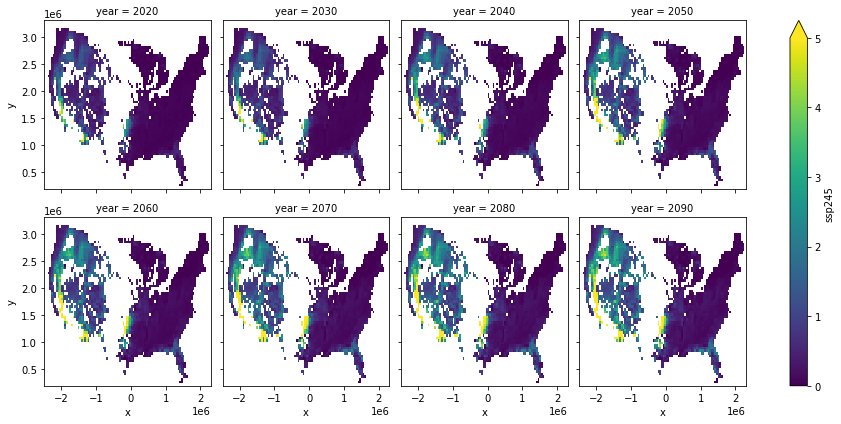

In [15]:
(future/benchmark_value)['ssp245'].clip(min=0).plot(vmax=5, vmin=0, col_wrap=4, col='year')

In [16]:
out_ds = future/benchmark_value

In [17]:
out_ds = out_ds.assign_coords({'x': out_ds.x.astype('float32').values,
                     'y': out_ds.y.astype('float32').values,
                              'year' : out_ds.year.astype('int32').values})

In [18]:
out_ds['lat'] = out_ds['lat'].astype('float32')
out_ds['lon'] = out_ds['lon'].astype('float32')

In [19]:
out_ds = out_ds.astype('float32').chunk({'x': 25, 'y': 25, 'year': -1})

In [20]:
mapper = fsspec.get_mapper('s3://carbonplan-scratch/grist/relative_fire_risk.zarr')

In [153]:
encoding = {}
for entry in ['ssp245', 'ssp370', 'ssp585', 'x', 'y', 'year', 'lat', 'lon']:
    encoding[entry] = {"compressor": Zlib()}

In [155]:
out_ds.to_zarr(mapper, consolidated=True, mode='w', encoding=encoding)

# absolute change - "risk will increase by 4%"

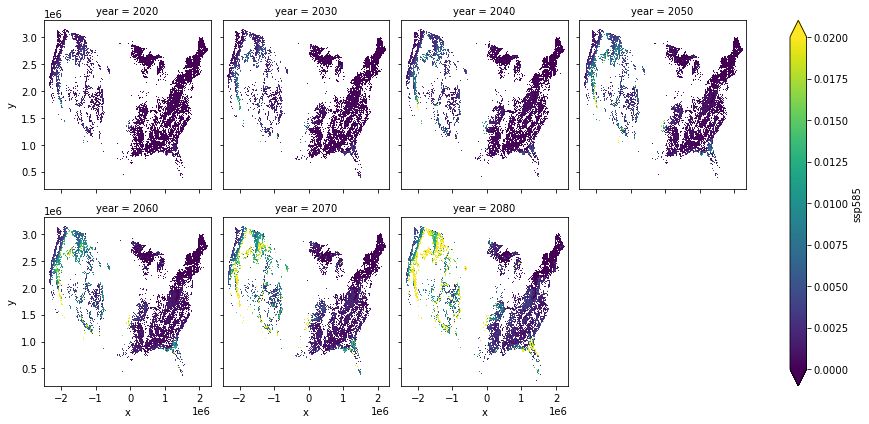

In [32]:
(future - past).plot(vmax=0.02, vmin=0, col_wrap=4, col='year')

In [34]:
# absolute risk itself

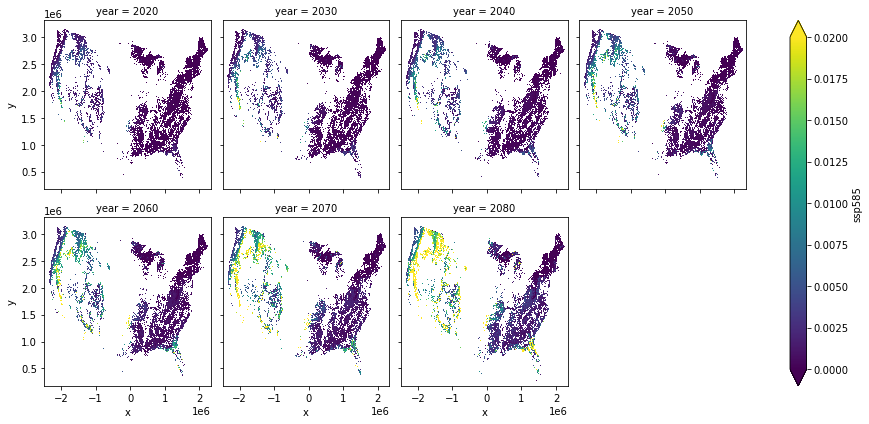

In [33]:
future.plot(vmax=0.02, vmin=0, col_wrap=4, col='year')

In [21]:
# Inspect one pixel to see how modelled risks change in an individual pixel

In [23]:
olympics = {'x': -2e6, 'y': 2.8e6}

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


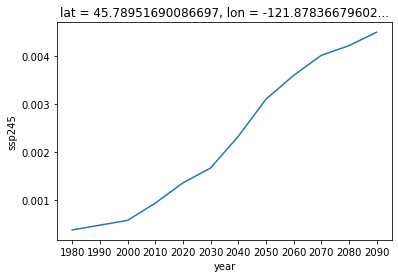

In [24]:
ds['ssp245'].sel(**olympics, method='nearest').plot()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


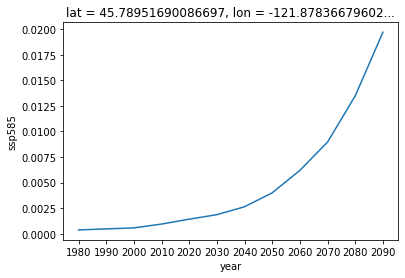

In [25]:
ds['ssp585'].sel(**olympics, method='nearest').plot()